In [12]:
#import and setup
import pandas as pd
import os
import matplotlib.pyplot as plt # for graphs
%matplotlib inline

Date
2020-01-06    24.629999
2020-01-07    24.950001
2020-01-08    24.860001
2020-01-09    24.889999
2020-01-10    25.120001
                ...    
2020-12-31    22.700001
2021-01-01    22.700001
2021-01-04    23.040001
2021-01-05    22.969999
2021-01-06    22.780001
Freq: B, Name: Close, Length: 263, dtype: float64

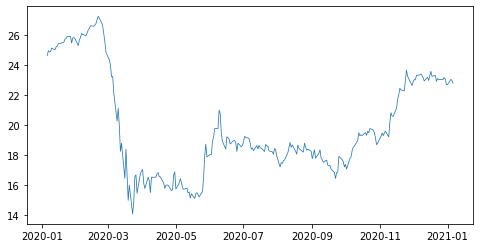

In [25]:
# טיפול בגרף
df = pd.read_csv(
   'D:\yudgimel\project\ANZ.AX.csv',
   index_col='Date', # dates parsed as index
   parse_dates=True,
   dayfirst=True ) # required as dates in csv are DD/MM/YYYY 

df = df.asfreq('B') # B for Business calendar (no weekends) 
df = df.fillna(method='ffill') # fills any missing day's data with previous day's

closing_prices = df.Close # takes column labelled 'Close'

plt.figure(figsize=(8,4)) # size of graph
plt.plot(df['Close'],label = 'close price history',alpha=1) # show 

#(the index of dataframe id date already. and we show the close coloumn)
closing_prices

In [14]:
type(df)

pandas.core.frame.DataFrame

In [15]:
class movAvg():
    def __init__(self, closing_prices):
        self.data = pd.DataFrame(closing_prices)

    # This implementation sets the default averaging length to 50 days 
    # returns a data-frame of the averaged prices with their corresponding date index
    # calculate 50 days 
    def EMA(self, averaging_length=50):
        ret = self.data.ewm( span=averaging_length, adjust=False).mean()
        return ret.rename(columns={'Close': 'EMA'})

    # calculate the MACD line, signal line and histogram
    def MACD(self, a=12, b=26, c=9):
        MACD_line = self.EMA(a) - self.EMA(b)
        signal_line = MACD_line.ewm(span=c, adjust=False).mean()
        histogram = MACD_line - signal_line
        return MACD_line, signal_line, histogram

# Executing class

MACD_indicator = movAvg(closing_prices)
MACD_line, signal_line, histogram = MACD_indicator.MACD()


In [16]:
buy = pd.DataFrame(index=closing_prices.index, columns=['Buy']) # an empty data-frame to store buy signals
sell = pd.DataFrame(index=closing_prices.index, columns=['Sell']) # an empty data-frame to store sell signals

for i in range(1, len(closing_prices)): 
    if i == 1: # ignores first value of historical data as MACD will be equal to signal line there
        if MACD_line['EMA'].iloc[i] > signal_line['EMA'].iloc[i]:
            high = 'MACD'
        else:
            high = 'SIGNAL'
    elif MACD_line['EMA'].iloc[i] > signal_line['EMA'].iloc[i]:
        if high == 'SIGNAL': # MACD crossed signal - bottom to top BUY
            if MACD_line['EMA'].iloc[i] < 0: 
                buy.iloc[i] = closing_prices[i] # BUY
            high = 'MACD'
    elif MACD_line['EMA'].iloc[i] < signal_line['EMA'].iloc[i]:
        if high == 'MACD': # MACD crossed signal - top to bottom SELL
            if MACD_line['EMA'].iloc[i] > 0:
                sell.iloc[i] = closing_prices[i] # SELL
            high = 'SIGNAL'

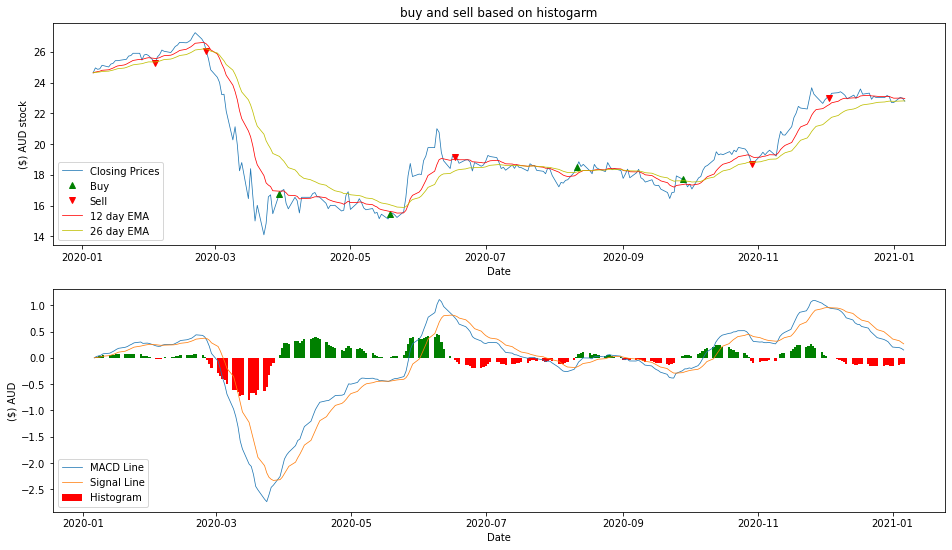

In [17]:
# Plotting results 
plt.rcParams["figure.figsize"] = [16,9] # size of graph
plt.rcParams["lines.linewidth"] = 0.75

fig, (ax1, ax2) = plt.subplots(2) # Create a figure and a set of subplots

# subplot 1 - shows where to buy and sell (based on where MACD and signal line meet)
ax1.plot(closing_prices, label = 'Closing Prices') # add closing_prices line to graph
ax1.plot(buy, 'g^', label = 'Buy')
ax1.plot(sell, 'rv', label = 'Sell')
ax1.plot(MACD_indicator.EMA(12), 'r', label = '12 day EMA') #  plot the 12 day EMA 
ax1.plot(MACD_indicator.EMA(26), 'y', label = '26 day EMA') #  plot the 26 day EMA 
ax1.legend(loc='lower left') # legend is an area describing the elements of the graph.
ax1.title.set_text('buy and sell based on histogarm')
ax1.set(xlabel='Date', ylabel='($) AUD stock')

# subplot 2 
ax2.plot(MACD_line, label = 'MACD Line')
ax2.plot(signal_line, label = 'Signal Line')
histogram_y = [histogram['EMA'].iloc[i] for i in range(0, len(histogram))]
 # green if histogram is above zero and red if hhistogram is below zero
ax2.bar(histogram.index, histogram_y, 
        color=['g' if histogram_y[i] > 0 else 'r' for i in range(0,len(histogram_y))],
        width = 1, label = 'Histogram')
ax2.legend(loc='lower left')
ax2.set(xlabel='Date', ylabel='($) AUD')

plt.show()
